In [7]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib import cm

In [3]:
from os import listdir
from os.path import isfile, join
import json
from pprint import pprint
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline
mypath = "trams/output_trams/"
onlyfiles = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
locations = {"col1": [], "col2": [] , "line": [], "heading": []}
lines = {}
visited = {}
for file in onlyfiles[:1000]:
    with open(file) as f:
        try:
            data = json.load(f)
            for element in data["vehicles"]:
                if ("category" in element 
                        and element["category"] == "tram"
                        and "latitude" in element 
                        and "longitude" in element
                        and "name" in element
                        and "heading" in element):
                    latitude = element["latitude"]
                    longitude = element["longitude"]
                    heading = element['heading']
                    if len(element["name"].split(" ")[0])>0 and element["name"].split(" ")[0].isdigit():
                        line = element["name"].split(" ")[0]
                        if element["tripId"] not in visited:
                            visited["tripId"] = True
                            if line not in lines:
                                lines[line] = 0
                            lines[line] += 1
                        locations["col1"].append(longitude/3600000)
                        locations["col2"].append(latitude/3600000)
                        locations["line"].append(int(line))
                        locations["heading"].append(float(heading))
        except json.decoder.JSONDecodeError:
            pass


In [4]:
import pandas
nplocations = np.array([locations["col1"], locations["col2"], locations["line"], locations['heading']])
print(nplocations.shape)
np.random.shuffle(nplocations.T)
nplocations = nplocations[:,:10000]
print(nplocations)
df = pd.DataFrame.from_records(data=nplocations.T, columns=['longitude', 'latitude', 'line', 'heading'])

(4, 103979)
[[ 19.93756944  20.0653125   20.01013889 ...  19.94513889  19.97364583
   20.01548611]
 [ 50.06966333  50.09492389  50.09421778 ...  50.07289778  50.03167
   50.07360389]
 [ 18.          79.          14.         ...  73.          50.
   73.        ]
 [135.         180.         270.         ... 180.          45.
   90.        ]]


/home/lemurpwned/.local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


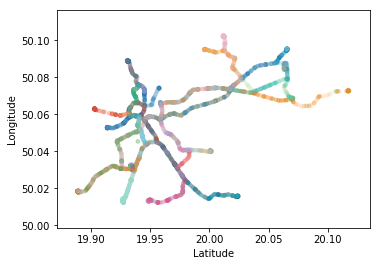

In [5]:
cmap = plt.get_cmap("tab20")
plt.scatter(nplocations[0], nplocations[1], alpha=0.1, s=13, label=np.array(nplocations[2]), c=cmap(nplocations[2]/nplocations[2].max()))
plt.axes().set_aspect(1.56)
plt.ylabel("Longitude")
plt.xlabel("Latitude")
plt.show()

In [8]:
# each line has unique color
max_line = int(np.max(df['line'])) 
colors = cm.rainbow(np.linspace(0, 1, max_line))

df['color'] = df['line'].map(lambda x: colors[int(x) - 1])

In [28]:
tsne = TSNE(n_components=2, perplexity=50.0)
clf = KMeans(n_clusters=5, n_jobs=-1)
Y = tsne.fit_transform(df[['longitude', 'latitude', 'line', 'heading']])

Text(0.5, 1.0, 'TRAMS')

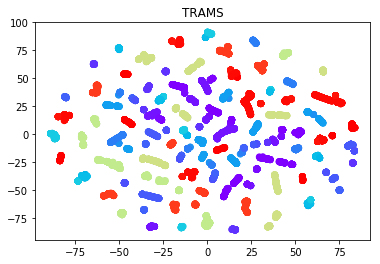

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
n_colors = df['color'].values.tolist()
ax.scatter(Y[:, 0], Y[:, 1], color=n_colors)
plt.title("TRAMS")

Text(0.5, 1.0, 'TRAMS')

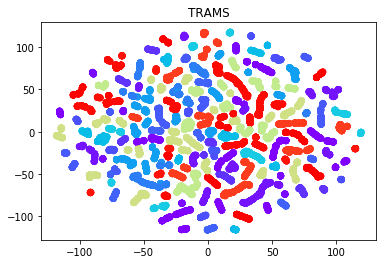

In [38]:
tsne = TSNE(n_components=2, perplexity=20.0)
Y = tsne.fit_transform(df[['longitude', 'latitude', 'line', 'heading']])
fig = plt.figure()
ax = fig.add_subplot(111)
n_colors = df['color'].values.tolist()
ax.scatter(Y[:, 0], Y[:, 1], color=n_colors)
plt.title("TRAMS")

In [9]:
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.preprocessing import StandardScaler
import os 
import shutil
# Generating TSNE 
perplexity = 100
PATH = os.getcwd()
LOG_DIR = PATH + f'/tensorlog_trams/{perplexity}'
metadata = PATH + f'/tensorlog_trams/{perplexity}/metadata.tsv'
# os.makedirs(LOG_DIR)
with open(metadata, 'w') as metadata_file:
    for label in df['line'].values:
        metadata_file.write(f'{label}\n')
        
tsne = TSNE(n_components=3, perplexity=20.0)
# Y = tsne.fit_transform(df[['longitude', 'latitude', 'line', 'heading']])

print("CALCULATED TSNE")
## TensorFlow Variable from data
tf_data = tf.Variable(Y)
        ## Running TensorFlow Session
with tf.Session() as sess:
    saver = tf.train.Saver([tf_data])
    sess.run(tf_data.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'tf_data.ckpt'))
    config = projector.ProjectorConfig()

    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = tf_data.name

    # Link this tensor to its metadata(Labels) file
    embedding.metadata_path = metadata

    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

CALCULATED TSNE
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [45]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding
import matplotlib


comp = 2
neighs = 15
label = 'heading'
labels = df[label].astype(float).values

cmap = matplotlib.cm.get_cmap('viridis')
normalize = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
colors = [cmap(normalize(value)) for value in labels]


lle = LocallyLinearEmbedding(n_components=comp, n_neighbors=neighs, n_jobs=-1, eigen_solver='dense')
Y = lle.fit_transform(df[['longitude', 'latitude', 'heading']])

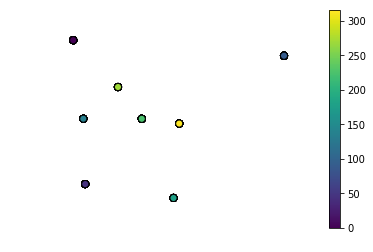

In [46]:
fig = plt.figure()
ax = plt.subplot(111)

ax.scatter(Y[:, 0], Y[:, 1], c=colors,
           s=50, edgecolor='k')
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

ax.axis('off')
plt.savefig(
    f'LLE_TRAM_FLIGHT_{neighs}_{label}_{len(labels)}', dpi=300)

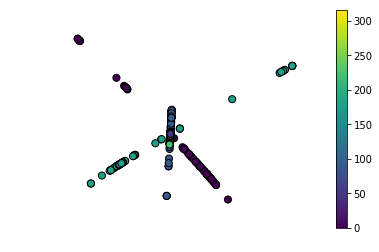

In [47]:
isomap = Isomap(n_components=comp, n_neighbors=neighs, n_jobs=-1, eigen_solver='dense')
Y = isomap.fit_transform(df[['longitude', 'latitude', 'heading']])
fig = plt.figure()
ax = plt.subplot(111)

ax.scatter(Y[:, 0], Y[:, 1], c=colors,
           s=50, edgecolor='k')
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
ax.axis('off')
plt.savefig(
    f'ISOMAP_TRAMS_{neighs}_{label}_{len(labels)}', dpi=300)

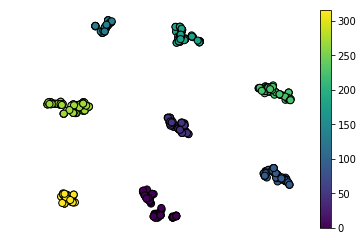

In [38]:
perplexity = 25
tsne = TSNE(n_components=2, perplexity=perplexity)



Y = tsne.fit_transform(df[['longitude', 'latitude', 'heading']])

fig = plt.figure()
ax = plt.subplot(111)
label = 'heading'
labels = df[label].astype(float).values
cmap = matplotlib.cm.get_cmap('viridis')
normalize = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
colors = [cmap(normalize(value)) for value in labels]

ax.scatter(Y[:, 0], Y[:, 1], c=colors,
           s=50, edgecolor='k')
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

ax.axis('off')
plt.savefig(
    f'TSNE_TRAM_{perplexity}_{label}{len(labels)}', dpi=300)